In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from feature_engine.creation import CyclicalFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from tensorflow.keras import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
sb.set()

In [103]:
url = "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_air_passengers.csv"

data=pd.read_csv(url)
data

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


In [104]:
data.set_index("ds", inplace=True)

In [105]:
data.index=pd.to_datetime(data.index)

In [106]:
data

,y
ds,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


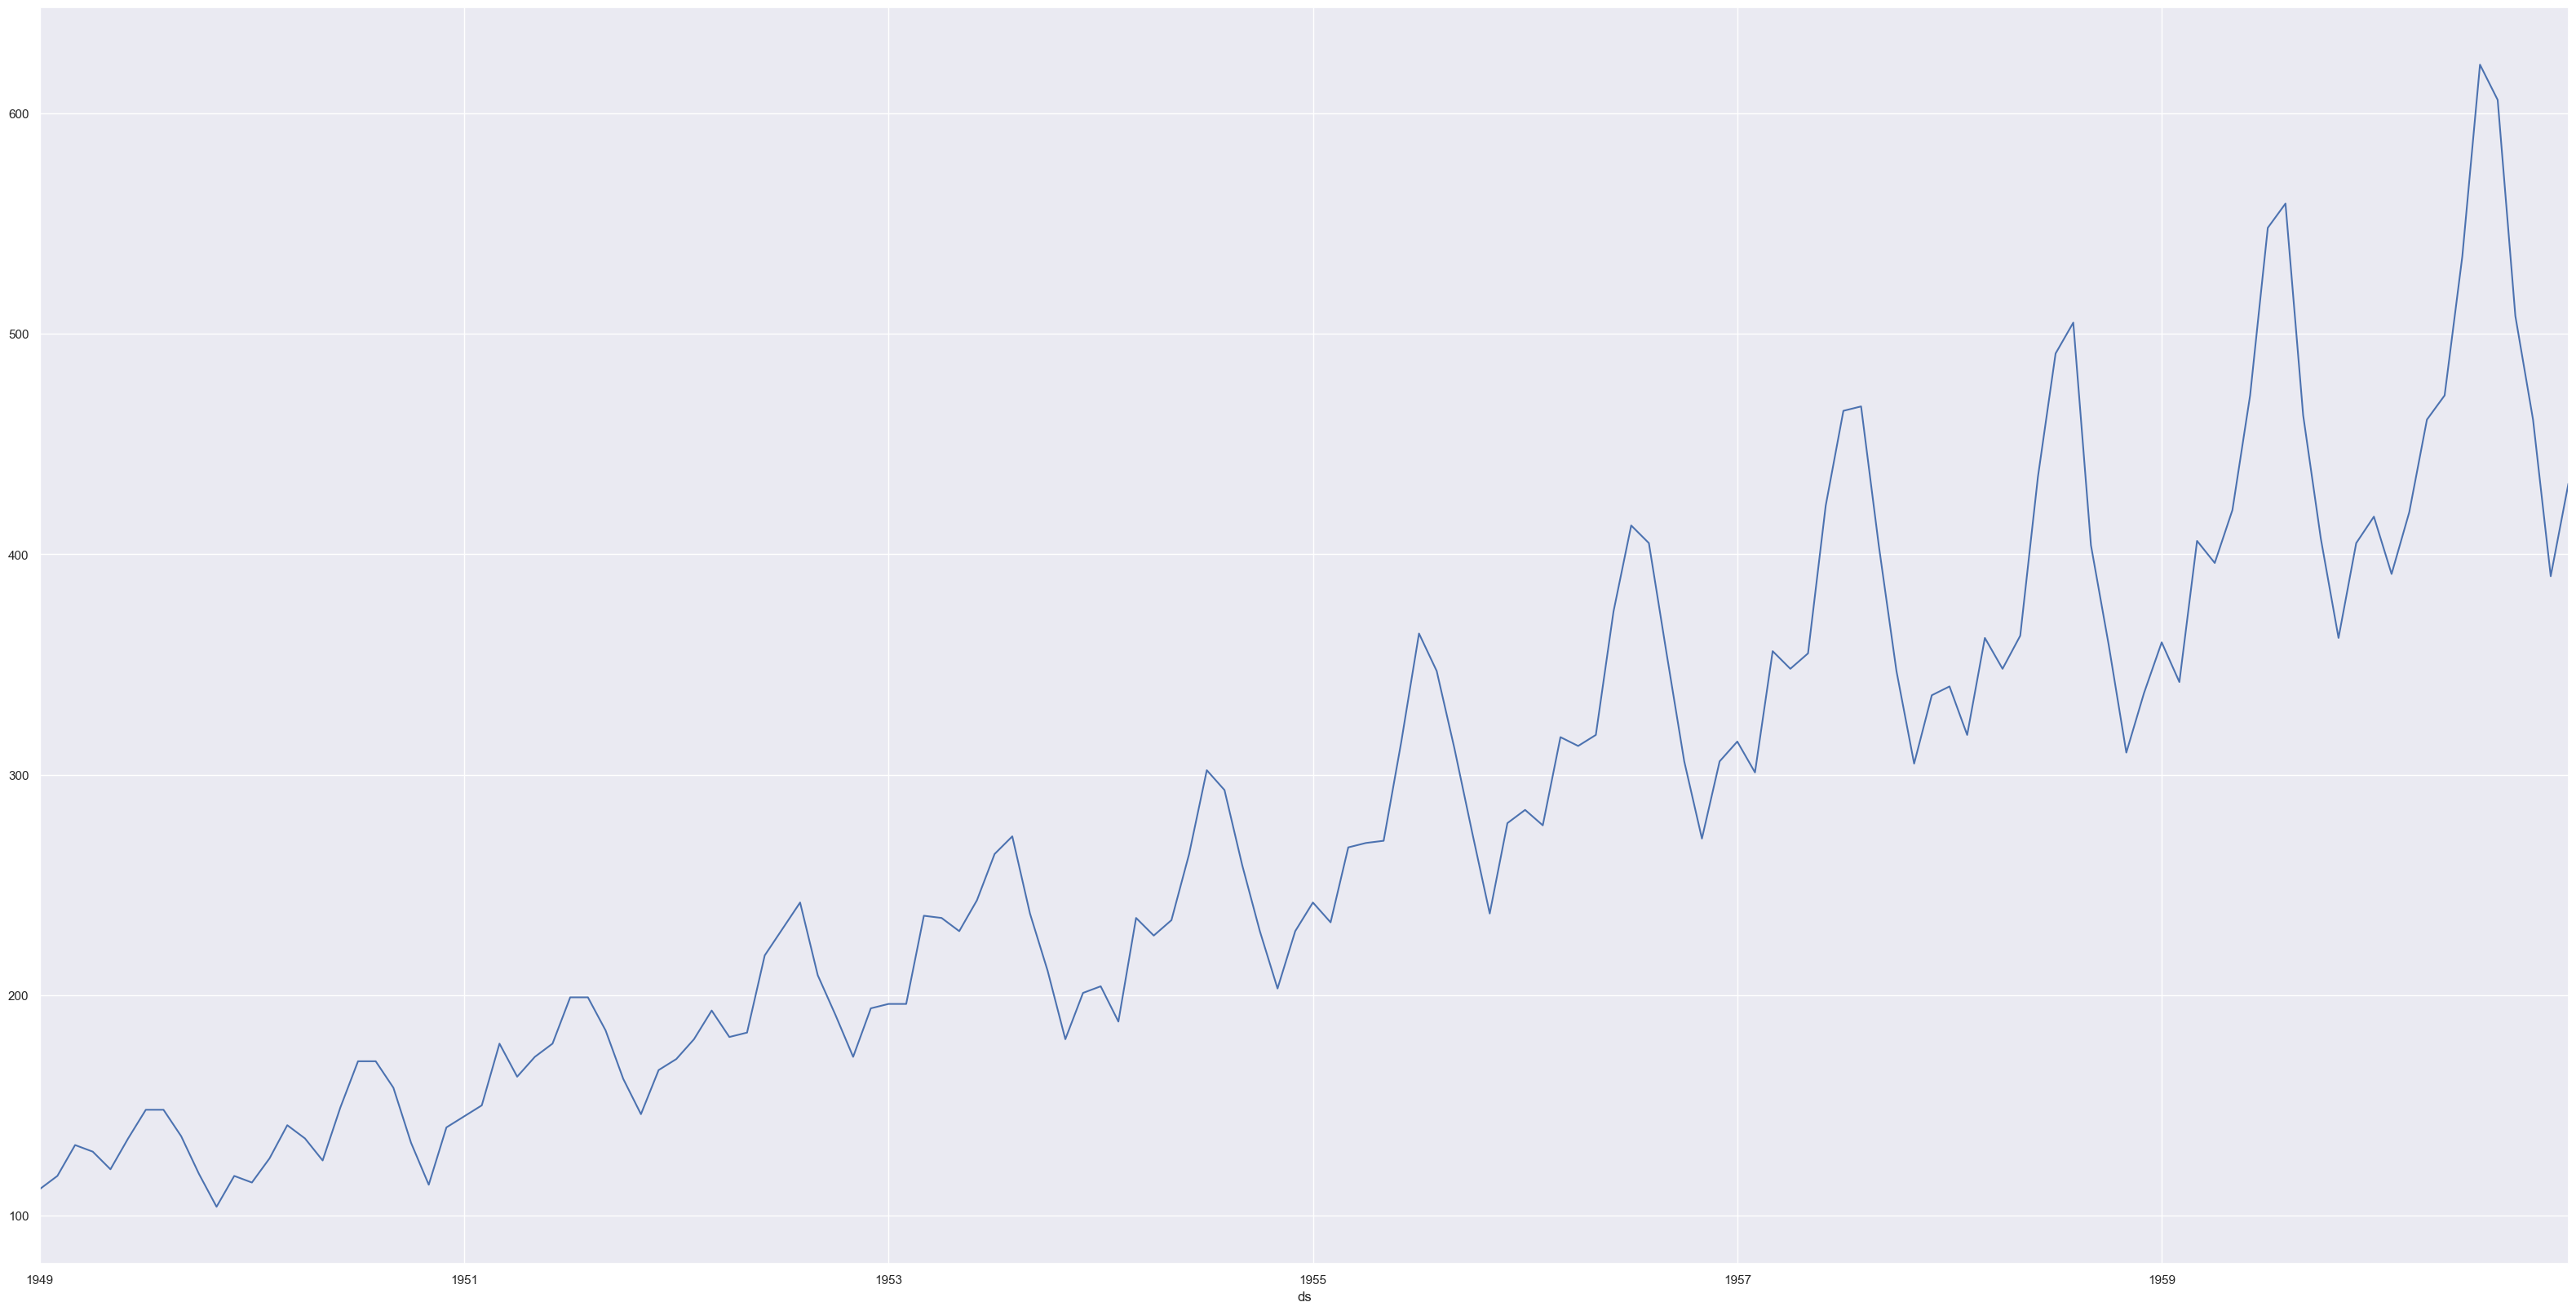

In [107]:
for var in ['y']:
    
    data[var].plot(figsize=(40,20))
    
    plt.show()

In [108]:
data.isna().sum()

y    0
dtype: int64

In [109]:
month_ = data.index.month

month_ = pd.Series(month_, index=data.index)

month_.head()

ds
1949-01-01    1
1949-02-01    2
1949-03-01    3
1949-04-01    4
1949-05-01    5
Name: ds, dtype: int64

Text(0, 0.5, 'Demand')

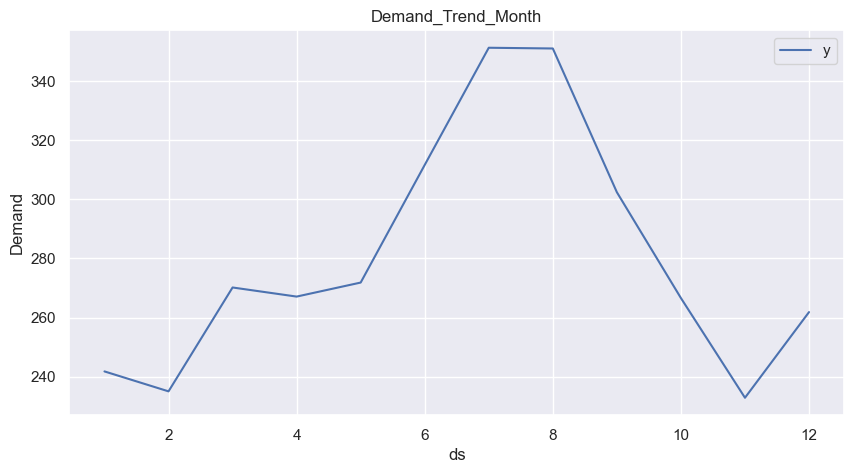

In [110]:
data.groupby(month_)[["y"]].mean().plot(figsize=(10, 5))
plt.title("Demand_Trend_Month")
plt.ylabel("Demand")

In [111]:
data['Month']=data.index.month
data['Year']=data.index.year
data['Week']=data.index.isocalendar().week

data

,y,Month,Year,Week
ds,,,,
1949-01-01,112,1,1949,53
1949-02-01,118,2,1949,5
1949-03-01,132,3,1949,9
1949-04-01,129,4,1949,13
1949-05-01,121,5,1949,17
...,...,...,...,...
1960-08-01,606,8,1960,31
1960-09-01,508,9,1960,35
1960-10-01,461,10,1960,39


In [112]:
cyclical = CyclicalFeatures(
    variables=["Month", "Week"],  # The features we want to transform.
    drop_original=False,  # Whether to drop the original features.
)

data = cyclical.fit_transform(data)

In [113]:
data

,y,Month,Year,Week,Month_sin,Month_cos,Week_sin,Week_cos
ds,,,,,,,,
1949-01-01,112,1,1949,53,5.000000e-01,8.660254e-01,-0.0,1.0
1949-02-01,118,2,1949,5,8.660254e-01,5.000000e-01,0.558647,0.829406
1949-03-01,132,3,1949,9,1.000000e+00,6.123234e-17,0.875735,0.482792
1949-04-01,129,4,1949,13,8.660254e-01,-5.000000e-01,0.999561,0.029633
1949-05-01,121,5,1949,17,5.000000e-01,-8.660254e-01,0.902798,-0.430065
...,...,...,...,...,...,...,...,...
1960-08-01,606,8,1960,31,-8.660254e-01,-5.000000e-01,-0.508531,-0.861044
1960-09-01,508,9,1960,35,-1.000000e+00,-1.836970e-16,-0.845596,-0.533823
1960-10-01,461,10,1960,39,-8.660254e-01,5.000000e-01,-0.99605,-0.088796


In [114]:
variables = ["y"]

# Shift the data forward 1 Hr.
tmp = data[variables].shift(1)

# Names for the new variables.
tmp.columns = [v + "_lag_1" for v in variables]

# Add the variables to the original data.
print("data size before")
print(data.shape)

data = data.merge(tmp, left_index=True, right_index=True, how="left")

print("data size after")
print(data.shape)

data

data size before
(144, 8)
data size after
(144, 9)


,y,Month,Year,Week,Month_sin,Month_cos,Week_sin,Week_cos,y_lag_1
ds,,,,,,,,,
1949-01-01,112,1,1949,53,5.000000e-01,8.660254e-01,-0.0,1.0,NaN
1949-02-01,118,2,1949,5,8.660254e-01,5.000000e-01,0.558647,0.829406,112.0
1949-03-01,132,3,1949,9,1.000000e+00,6.123234e-17,0.875735,0.482792,118.0
1949-04-01,129,4,1949,13,8.660254e-01,-5.000000e-01,0.999561,0.029633,132.0
1949-05-01,121,5,1949,17,5.000000e-01,-8.660254e-01,0.902798,-0.430065,129.0
...,...,...,...,...,...,...,...,...,...
1960-08-01,606,8,1960,31,-8.660254e-01,-5.000000e-01,-0.508531,-0.861044,622.0
1960-09-01,508,9,1960,35,-1.000000e+00,-1.836970e-16,-0.845596,-0.533823,606.0
1960-10-01,461,10,1960,39,-8.660254e-01,5.000000e-01,-0.99605,-0.088796,508.0


In [115]:
data.dropna(inplace=True)

In [116]:
for window in [2, 4]:
    
    tmp = data["y"].rolling(window=window).agg(["mean", "max", "min"]).shift(1)

    tmp.columns = [f"sales_{window}_{func}" for func in ["mean", "max", "min"]]
    
    data = data.merge(tmp, left_index=True, right_index=True, how="left")

# view of the result
data

,y,Month,Year,Week,Month_sin,Month_cos,Week_sin,Week_cos,y_lag_1,sales_2_mean,sales_2_max,sales_2_min,sales_4_mean,sales_4_max,sales_4_min
ds,,,,,,,,,,,,,,,
1949-02-01,118,2,1949,5,8.660254e-01,5.000000e-01,0.558647,0.829406,112.0,NaN,NaN,NaN,NaN,NaN,NaN
1949-03-01,132,3,1949,9,1.000000e+00,6.123234e-17,0.875735,0.482792,118.0,NaN,NaN,NaN,NaN,NaN,NaN
1949-04-01,129,4,1949,13,8.660254e-01,-5.000000e-01,0.999561,0.029633,132.0,125.0,132.0,118.0,NaN,NaN,NaN
1949-05-01,121,5,1949,17,5.000000e-01,-8.660254e-01,0.902798,-0.430065,129.0,130.5,132.0,129.0,NaN,NaN,NaN
1949-06-01,135,6,1949,22,1.224647e-16,-1.000000e+00,0.508531,-0.861044,121.0,125.0,129.0,121.0,125.00,132.0,118.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1960-08-01,606,8,1960,31,-8.660254e-01,-5.000000e-01,-0.508531,-0.861044,622.0,578.5,622.0,535.0,522.50,622.0,461.0
1960-09-01,508,9,1960,35,-1.000000e+00,-1.836970e-16,-0.845596,-0.533823,606.0,614.0,622.0,606.0,558.75,622.0,472.0
1960-10-01,461,10,1960,39,-8.660254e-01,5.000000e-01,-0.99605,-0.088796,508.0,557.0,606.0,508.0,567.75,622.0,508.0


In [117]:
data.dropna(inplace=True)
data

,y,Month,Year,Week,Month_sin,Month_cos,Week_sin,Week_cos,y_lag_1,sales_2_mean,sales_2_max,sales_2_min,sales_4_mean,sales_4_max,sales_4_min
ds,,,,,,,,,,,,,,,
1949-06-01,135,6,1949,22,1.224647e-16,-1.000000e+00,0.508531,-0.861044,121.0,125.0,129.0,121.0,125.00,132.0,118.0
1949-07-01,148,7,1949,26,-5.000000e-01,-8.660254e-01,0.059241,-0.998244,135.0,128.0,135.0,121.0,129.25,135.0,121.0
1949-08-01,148,8,1949,31,-8.660254e-01,-5.000000e-01,-0.508531,-0.861044,148.0,141.5,148.0,135.0,133.25,148.0,121.0
1949-09-01,136,9,1949,35,-1.000000e+00,-1.836970e-16,-0.845596,-0.533823,148.0,148.0,148.0,148.0,138.00,148.0,121.0
1949-10-01,119,10,1949,39,-8.660254e-01,5.000000e-01,-0.99605,-0.088796,136.0,142.0,148.0,136.0,141.75,148.0,135.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1960-08-01,606,8,1960,31,-8.660254e-01,-5.000000e-01,-0.508531,-0.861044,622.0,578.5,622.0,535.0,522.50,622.0,461.0
1960-09-01,508,9,1960,35,-1.000000e+00,-1.836970e-16,-0.845596,-0.533823,606.0,614.0,622.0,606.0,558.75,622.0,472.0
1960-10-01,461,10,1960,39,-8.660254e-01,5.000000e-01,-0.99605,-0.088796,508.0,557.0,606.0,508.0,567.75,622.0,508.0


In [118]:
X_train = data[data.index <= "1958-07-01"]
X_test = data[data.index > "1958-07-01"]

X_train.shape, X_test.shape

((110, 15), (29, 15))

In [119]:
# the target variable
y_train = X_train["y"].copy()
y_test = X_test["y"].copy()

# the input features
X_train = X_train.drop("y", axis=1)
X_test = X_test.drop("y", axis=1)

In [120]:
print("train rmse: ", mean_squared_error(
    y_train, X_train["y_lag_1"], squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test, X_test["y_lag_1"], squared=False,))

train rmse:  27.351915339282417
test rmse:  52.4913786024544


In [121]:
# Define the model with GridSearchCV for hyperparameter tuning
model = RandomForestRegressor()

# Define the grid of parameters to search over
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': np.arange(5,15)
}

# Apply GridSearchCV to the pipeline
grid_search = HalvingGridSearchCV(model, param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Train the model
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters: ", best_params)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 12
max_resources_: 110
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 20
n_resources: 12
Fitting 5 folds for each of 20 candidates, totalling 100 fits
----------
iter: 1
n_candidates: 7
n_resources: 36
Fitting 5 folds for each of 7 candidates, totalling 35 fits
----------
iter: 2
n_candidates: 3
n_resources: 108
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters:  {'max_depth': 9, 'n_estimators': 200}


In [122]:
print("For Training Data:")

# Make predictions on the test data
y_pred_train = grid_search.predict(X_train)

# Evaluate the model
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mse_train=mean_squared_error(y_train, y_pred_train)

print("Mean Absolute Error: ", mae_train)
print("R2 Score: ", r2_train)
print("Mean Squared Error: ", mse_train)

print("For Test Data:")

# Make predictions on the test data
y_pred_test = grid_search.predict(X_test)

# Evaluate the model
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mse_test=mean_squared_error(y_test, y_pred_test)

print("Mean Absolute Error: ", mae_test)
print("R2 Score: ", r2_test)
print("Mean Squared Error: ", mse_test)

For Training Data:
Mean Absolute Error:  7.052611637478683
R2 Score:  0.9905907468334946
Mean Squared Error:  75.16887187335055
For Test Data:
Mean Absolute Error:  46.154955870279146
R2 Score:  0.4063731948990843
Mean Squared Error:  3623.788831943243


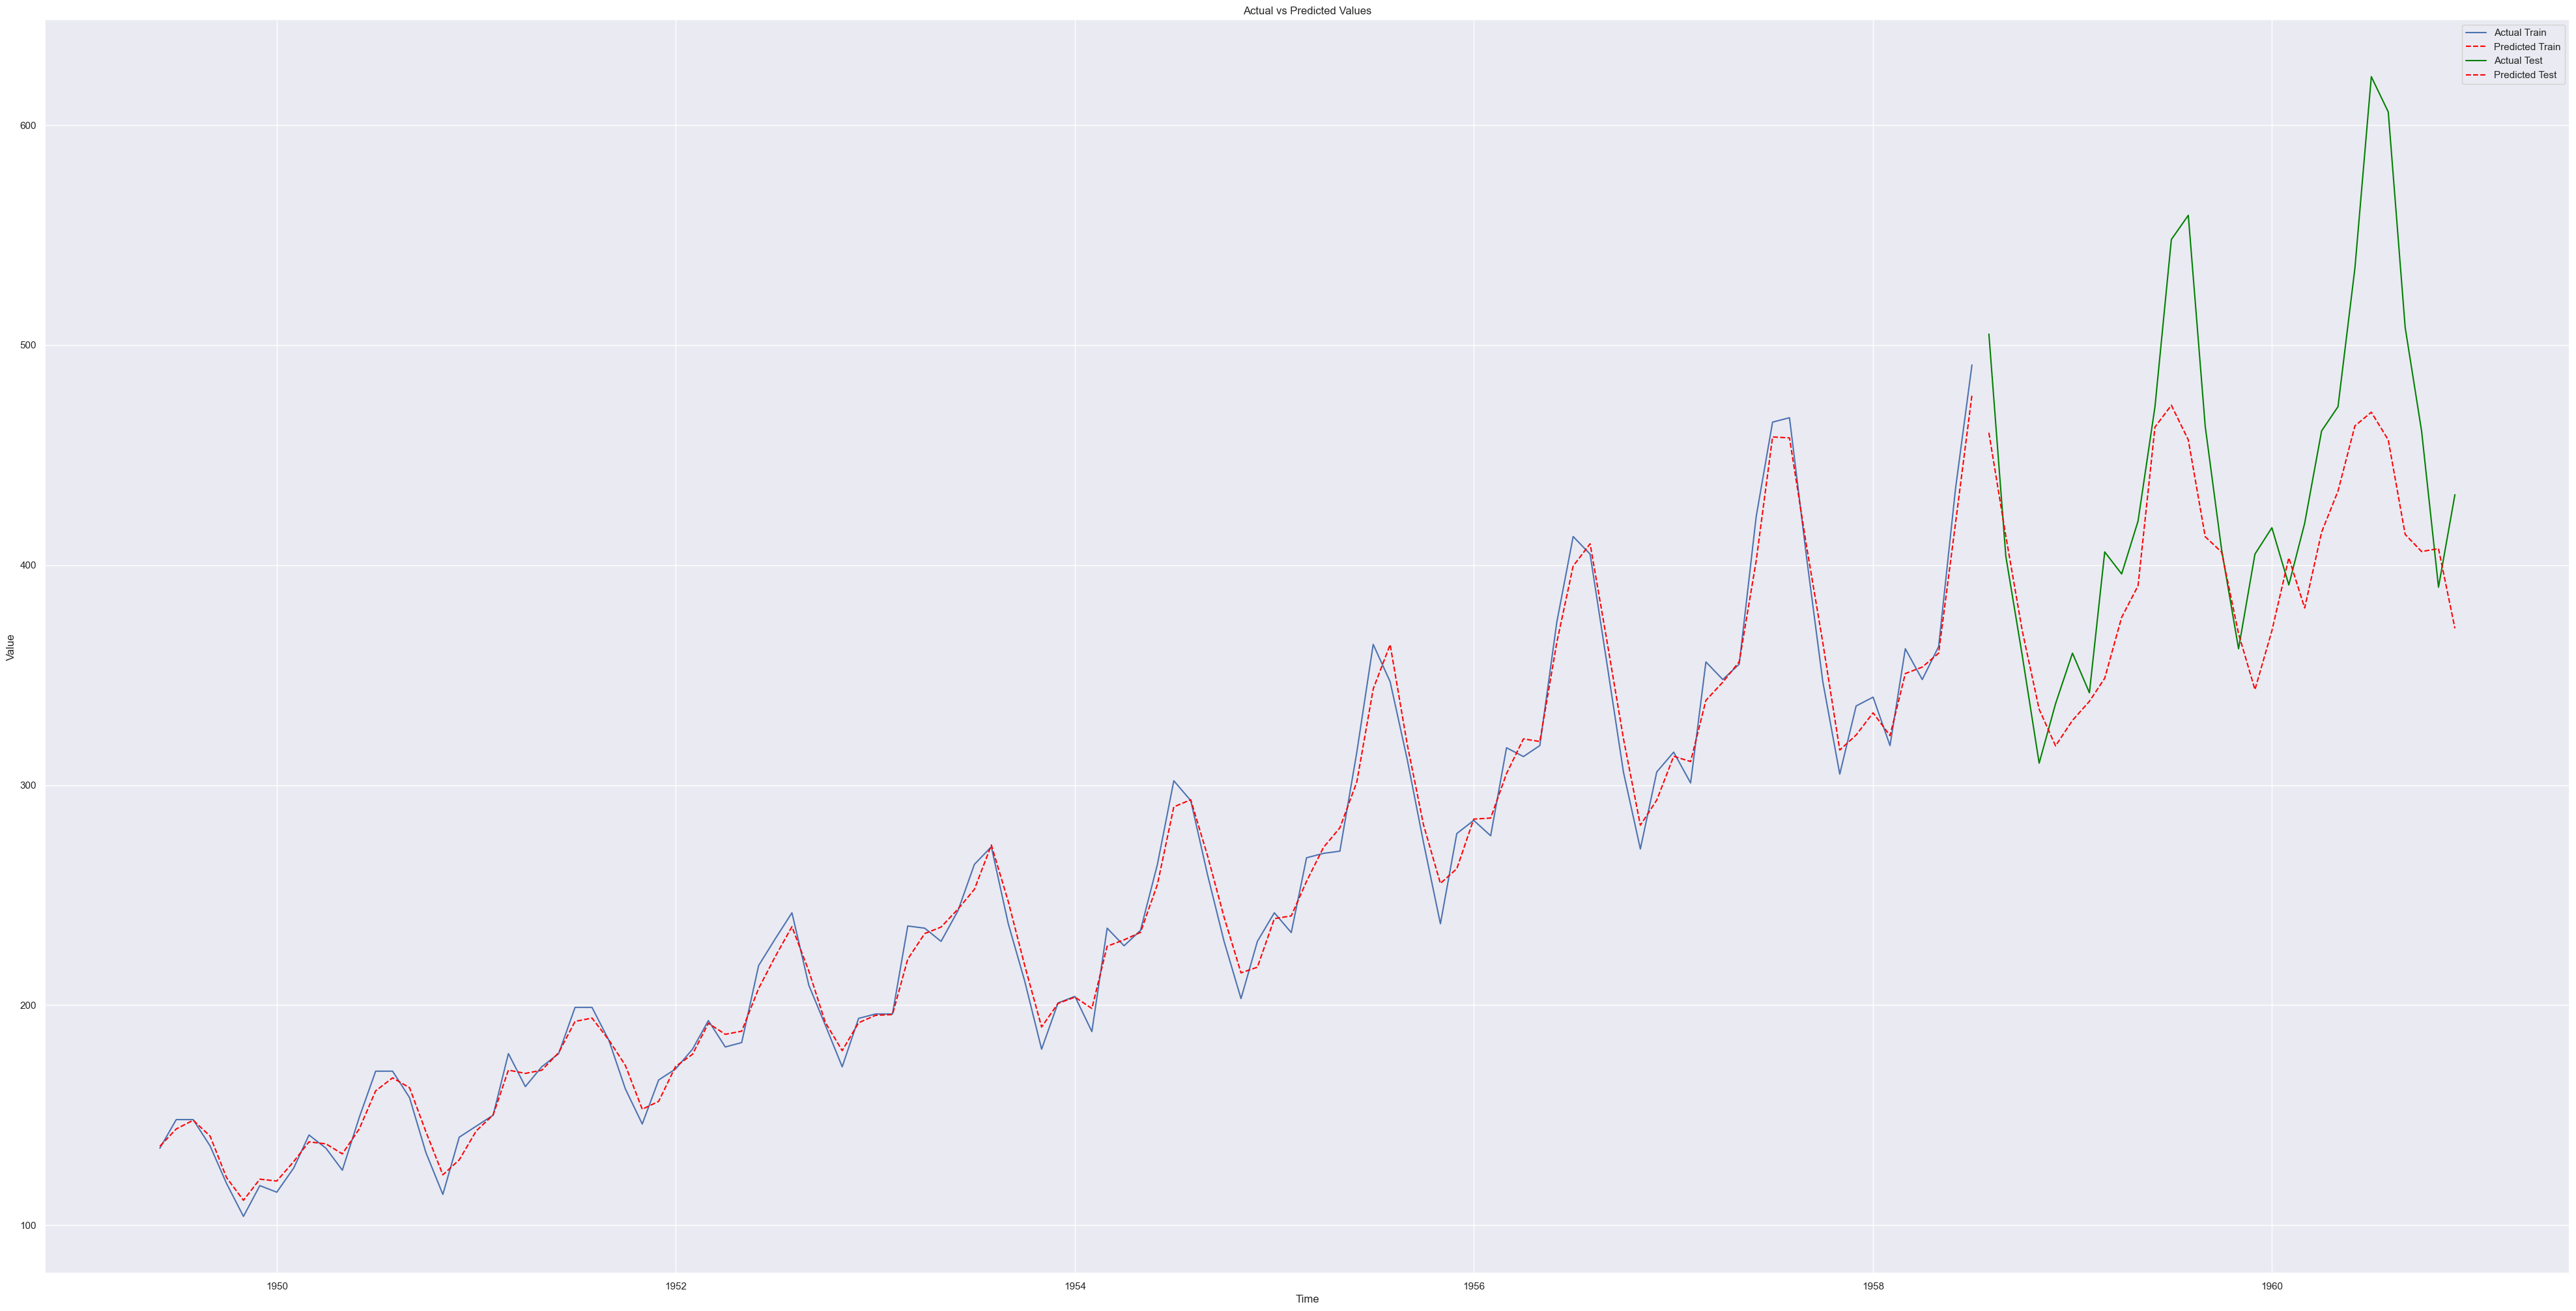

In [123]:
plt.figure(figsize=(50, 25))  # Set the figure size
plt.plot(y_train.index, y_train, label='Actual Train')  # Plot the actual values
plt.plot(y_train.index, y_pred_train, label='Predicted Train', linestyle='--', color='red')  # Plot the predicted values
plt.plot(y_test.index, y_test, label='Actual Test', color='green')  # Plot the actual values
plt.plot(y_test.index, y_pred_test, label='Predicted Test', linestyle='--', color='red')  # Plot the predicted values
plt.xlabel('Time')  # Label x-axis
plt.ylabel('Value')  # Label y-axis
plt.title('Actual vs Predicted Values')  # Title of the plot
plt.legend()  # Add a legend
plt.show()  # Display the plot

In [124]:
# Define the model
ridge = Ridge()

params = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]}

ridge_regressor = HalvingGridSearchCV(ridge, params,scoring='neg_mean_squared_error', n_jobs=-1, verbose=2, cv=5)

ridge_regressor.fit(X_train, y_train)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 12
max_resources_: 110
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 10
n_resources: 12
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------
iter: 1
n_candidates: 4
n_resources: 36
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 2
n_resources: 108
Fitting 5 folds for each of 2 candidates, totalling 10 fits


HalvingGridSearchCV(estimator=Ridge(), n_jobs=-1,
                    param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001,
                                          0.01, 1, 5, 10, 20]},
                    scoring='neg_mean_squared_error', verbose=2)

In [125]:
print("For Training Data:")

# Make predictions on the test data
y_pred_train = ridge_regressor.predict(X_train)

# Evaluate the model
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mse_train=mean_squared_error(y_train, y_pred_train)

print("Mean Absolute Error: ", mae_train)
print("R2 Score: ", r2_train)
print("Mean Squared Error: ", mse_train)

print("For Test Data:")

# Make predictions on the test data
y_pred_test = ridge_regressor.predict(X_test)

# Evaluate the model
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mse_test=mean_squared_error(y_test, y_pred_test)

print("Mean Absolute Error: ", mae_test)
print("R2 Score: ", r2_test)
print("Mean Squared Error: ", mse_test)

For Training Data:
Mean Absolute Error:  15.06586815799386
R2 Score:  0.9557056932852955
Mean Squared Error:  353.85944104563646
For Test Data:
Mean Absolute Error:  32.14408254427439
R2 Score:  0.7688754923691521
Mean Squared Error:  1410.8972208535395


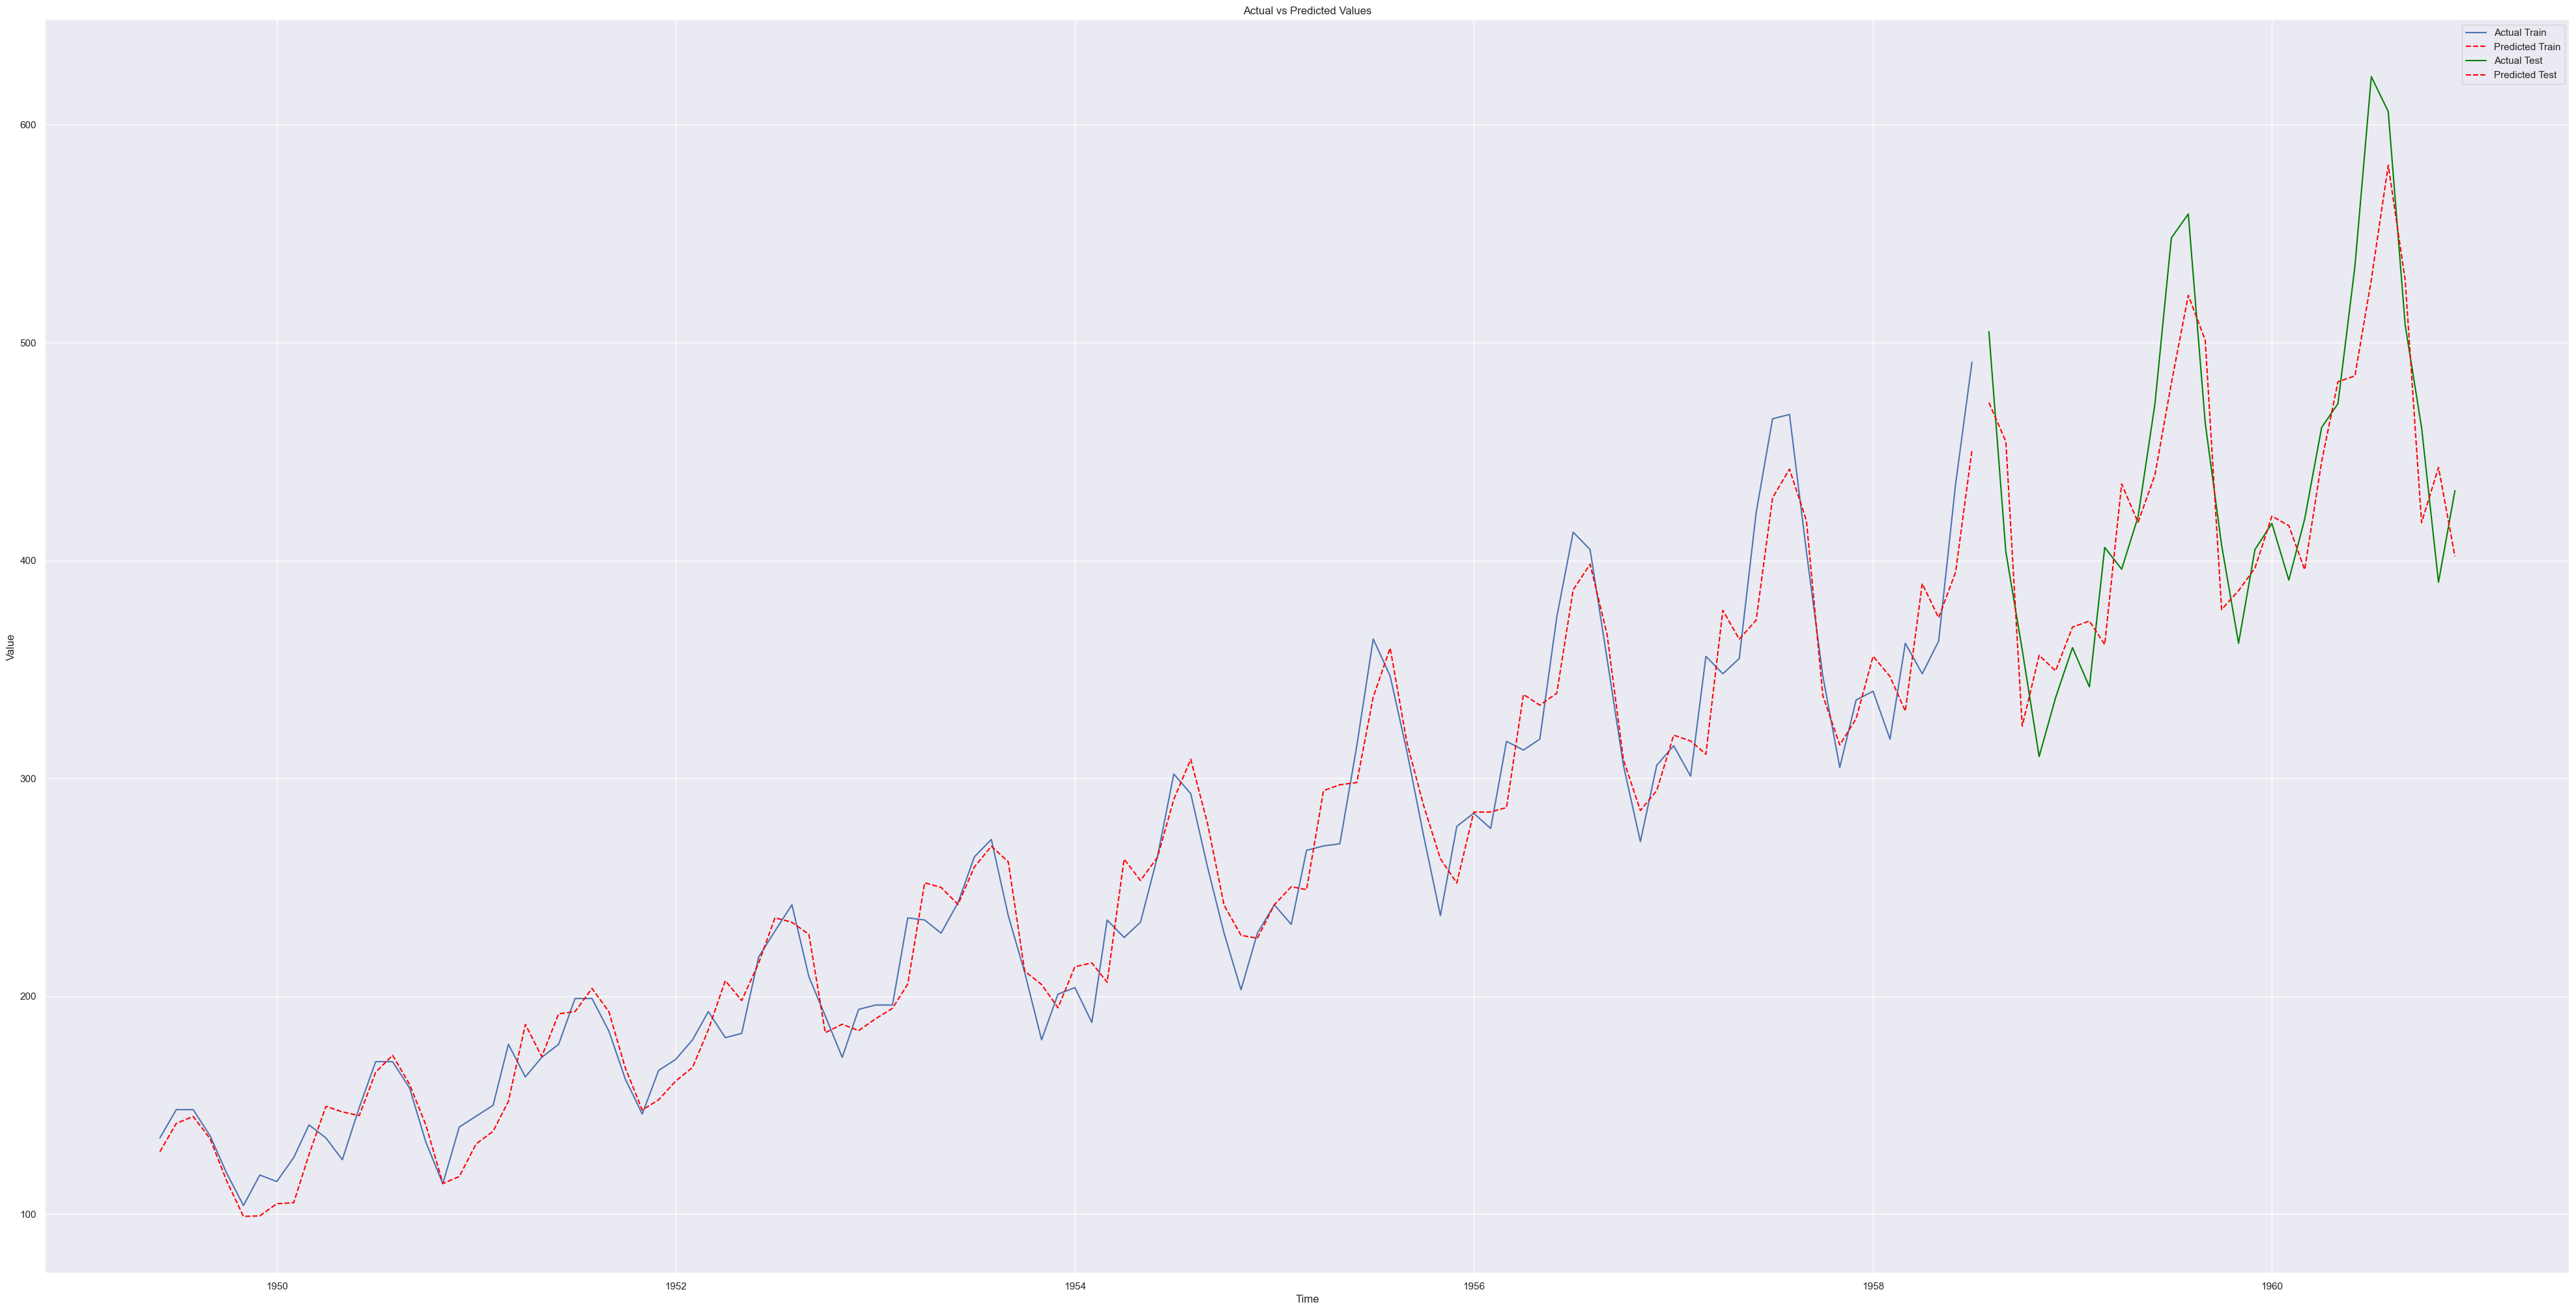

In [126]:
plt.figure(figsize=(50, 25))  # Set the figure size
plt.plot(y_train.index, y_train, label='Actual Train')  # Plot the actual values
plt.plot(y_train.index, y_pred_train, label='Predicted Train', linestyle='--', color='red')  # Plot the predicted values
plt.plot(y_test.index, y_test, label='Actual Test', color='green')  # Plot the actual values
plt.plot(y_test.index, y_pred_test, label='Predicted Test', linestyle='--', color='red')  # Plot the predicted values
plt.xlabel('Time')  # Label x-axis
plt.ylabel('Value')  # Label y-axis
plt.title('Actual vs Predicted Values')  # Title of the plot
plt.legend()  # Add a legend
plt.show()  # Display the plot

In [127]:
lasso = Lasso()

params = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}

lasso_regressor = HalvingGridSearchCV(lasso, params, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1, cv=5)

lasso_regressor.fit(X_train, y_train)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 12
max_resources_: 110
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 10
n_resources: 12
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------
iter: 1
n_candidates: 4
n_resources: 36
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 2
n_resources: 108
Fitting 5 folds for each of 2 candidates, totalling 10 fits


C:\Users\Admin\anaconda3\envs\bright\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.487e+02, tolerance: 8.788e+01
  model = cd_fast.enet_coordinate_descent(


HalvingGridSearchCV(estimator=Lasso(), n_jobs=-1,
                    param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001,
                                          0.01, 1, 5, 10, 20]},
                    scoring='neg_mean_squared_error', verbose=2)

In [128]:
print("For Training Data:")

# Make predictions on the test data
y_pred_train = lasso_regressor.predict(X_train)

# Evaluate the model
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mse_train=mean_squared_error(y_train, y_pred_train)

print("Mean Absolute Error: ", mae_train)
print("R2 Score: ", r2_train)
print("Mean Squared Error: ", mse_train)

print("For Test Data:")

# Make predictions on the test data
y_pred_test = lasso_regressor.predict(X_test)

# Evaluate the model
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mse_test=mean_squared_error(y_test, y_pred_test)

print("Mean Absolute Error: ", mae_test)
print("R2 Score: ", r2_test)
print("Mean Squared Error: ", mse_test)

For Training Data:
Mean Absolute Error:  19.522060813640394
R2 Score:  0.9286063214940773
Mean Squared Error:  570.3515653381016
For Test Data:
Mean Absolute Error:  38.850173148622865
R2 Score:  0.647445187784249
Mean Squared Error:  2152.1672878941145


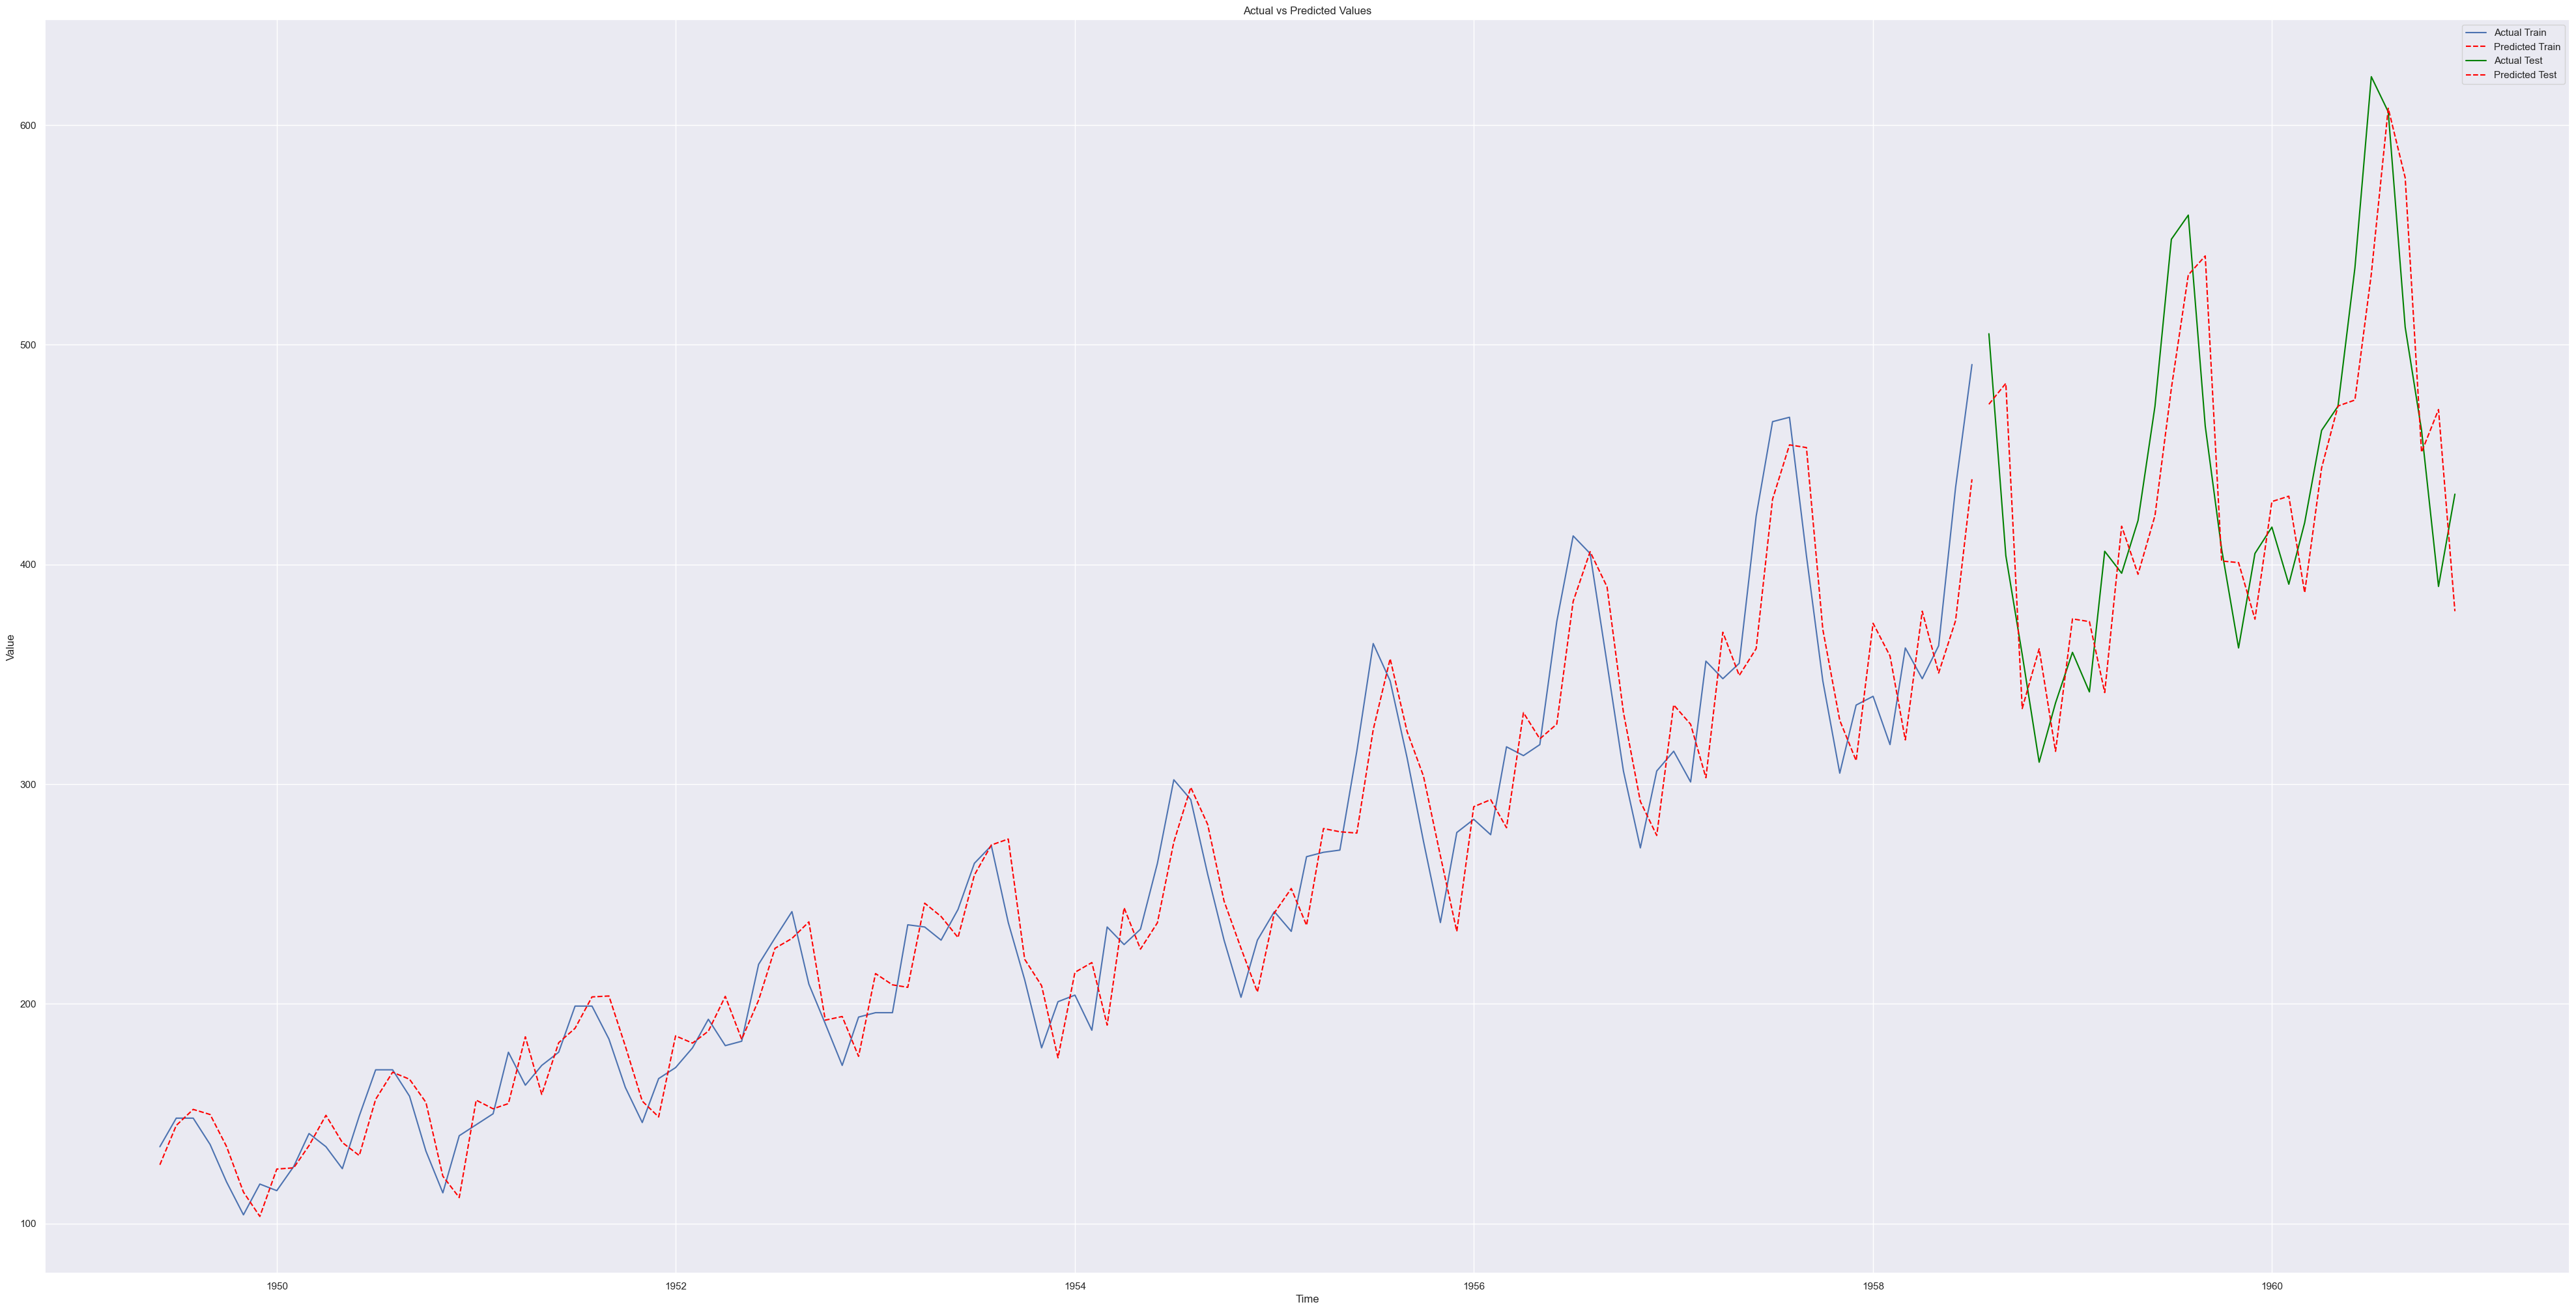

In [129]:
plt.figure(figsize=(50, 25))  # Set the figure size
plt.plot(y_train.index, y_train, label='Actual Train')  # Plot the actual values
plt.plot(y_train.index, y_pred_train, label='Predicted Train', linestyle='--', color='red')  # Plot the predicted values
plt.plot(y_test.index, y_test, label='Actual Test', color='green')  # Plot the actual values
plt.plot(y_test.index, y_pred_test, label='Predicted Test', linestyle='--', color='red')  # Plot the predicted values
plt.xlabel('Time')  # Label x-axis
plt.ylabel('Value')  # Label y-axis
plt.title('Actual vs Predicted Values')  # Title of the plot
plt.legend()  # Add a legend
plt.show()  # Display the plot

In [130]:
elastic_net = ElasticNet()

params = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20],
          'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}

elastic_net_regressor = HalvingGridSearchCV(elastic_net, params, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1, cv=5)

elastic_net_regressor.fit(X_train, y_train)


n_iterations: 3
n_required_iterations: 5
n_possible_iterations: 3
min_resources_: 10
max_resources_: 110
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 110
n_resources: 10
Fitting 5 folds for each of 110 candidates, totalling 550 fits
----------
iter: 1
n_candidates: 37
n_resources: 30
Fitting 5 folds for each of 37 candidates, totalling 185 fits
----------
iter: 2
n_candidates: 13
n_resources: 90
Fitting 5 folds for each of 13 candidates, totalling 65 fits


C:\Users\Admin\anaconda3\envs\bright\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.713e+03, tolerance: 8.788e+01
  model = cd_fast.enet_coordinate_descent(


HalvingGridSearchCV(estimator=ElasticNet(), n_jobs=-1,
                    param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001,
                                          0.01, 1, 5, 10, 20],
                                'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                             0.7, 0.8, 0.9, 1]},
                    scoring='neg_mean_squared_error', verbose=2)

In [131]:
print("For Training Data:")

# Make predictions on the test data
y_pred_train = elastic_net_regressor.predict(X_train)

# Evaluate the model
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mse_train=mean_squared_error(y_train, y_pred_train)

print("Mean Absolute Error: ", mae_train)
print("R2 Score: ", r2_train)
print("Mean Squared Error: ", mse_train)

print("For Test Data:")

# Make predictions on the test data
y_pred_test = elastic_net_regressor.predict(X_test)

# Evaluate the model
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mse_test=mean_squared_error(y_test, y_pred_test)

print("Mean Absolute Error: ", mae_test)
print("R2 Score: ", r2_test)
print("Mean Squared Error: ", mse_test)

For Training Data:
Mean Absolute Error:  15.25170957688315
R2 Score:  0.9552110720167204
Mean Squared Error:  357.8108835358561
For Test Data:
Mean Absolute Error:  32.28846278294277
R2 Score:  0.7671550473517861
Mean Squared Error:  1421.3996600734854


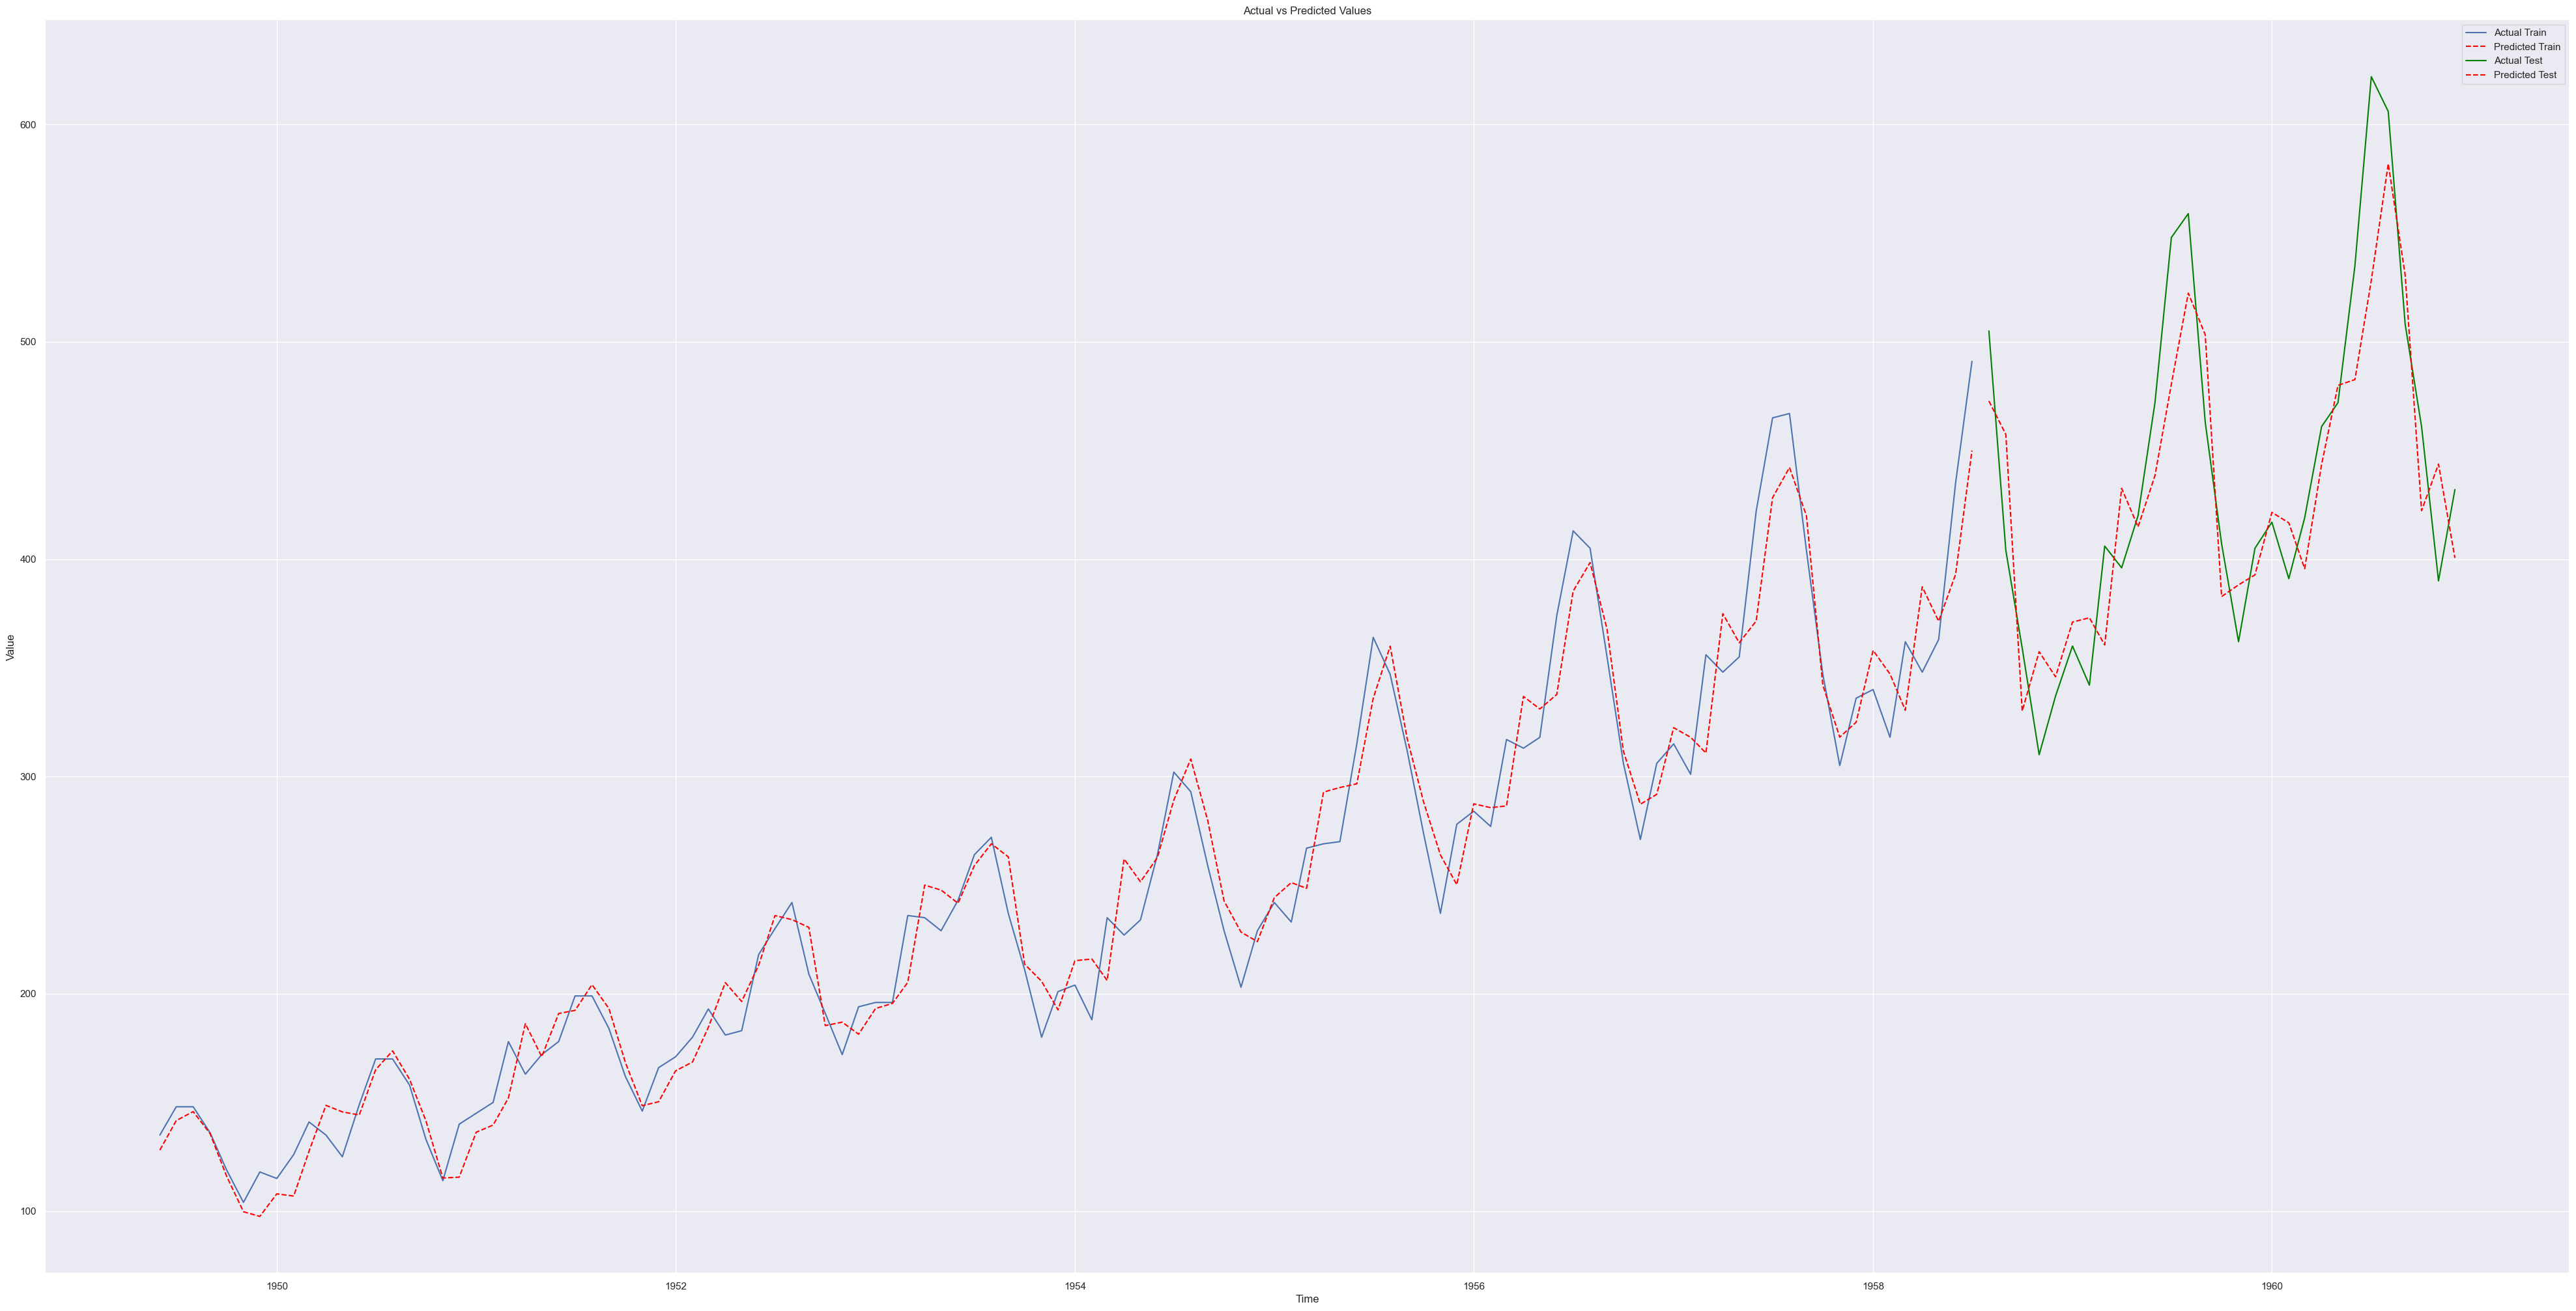

In [132]:
plt.figure(figsize=(50, 25))  # Set the figure size
plt.plot(y_train.index, y_train, label='Actual Train')  # Plot the actual values
plt.plot(y_train.index, y_pred_train, label='Predicted Train', linestyle='--', color='red')  # Plot the predicted values
plt.plot(y_test.index, y_test, label='Actual Test', color='green')  # Plot the actual values
plt.plot(y_test.index, y_pred_test, label='Predicted Test', linestyle='--', color='red')  # Plot the predicted values
plt.xlabel('Time')  # Label x-axis
plt.ylabel('Value')  # Label y-axis
plt.title('Actual vs Predicted Values')  # Title of the plot
plt.legend()  # Add a legend
plt.show()  # Display the plot

In [153]:
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

model = tf.keras.Sequential([
    layers.Dense(32, input_shape = (14,)) , 
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)), 
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)), 
#    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),

    layers.Dense(1, activation='linear') 
])


model.compile(loss='mean_squared_error',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

model.fit(X_train, y_train, epochs=2000)

Epoch 1/2000
4/4 [==============================] - 0s 2ms/step - loss: 183734.8125
Epoch 2/2000
4/4 [==============================] - 0s 2ms/step - loss: 37759.4805
Epoch 3/2000
4/4 [==============================] - 0s 4ms/step - loss: 10769.0547
Epoch 4/2000
4/4 [==============================] - 0s 4ms/step - loss: 4344.4902
Epoch 5/2000
4/4 [==============================] - 0s 4ms/step - loss: 1452.7098
Epoch 6/2000
4/4 [==============================] - 0s 3ms/step - loss: 1592.0631
Epoch 7/2000
4/4 [==============================] - 0s 4ms/step - loss: 1341.1603
Epoch 8/2000
4/4 [==============================] - 0s 4ms/step - loss: 1104.5710
Epoch 9/2000
4/4 [==============================] - 0s 4ms/step - loss: 1024.3636
Epoch 10/2000
4/4 [==============================] - 0s 3ms/step - loss: 1254.9993
Epoch 11/2000
4/4 [==============================] - 0s 3ms/step - loss: 1344.1512
Epoch 12/2000
4/4 [==============================] - 0s 4ms/step - loss: 1069.5590
Epoch 13/

In [154]:
print("For Training Data:")

# Make predictions on the test data
y_pred_train = model.predict(X_train)

# Evaluate the model
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mse_train=mean_squared_error(y_train, y_pred_train)

print("Mean Absolute Error: ", mae_train)
print("R2 Score: ", r2_train)
print("Mean Squared Error: ", mse_train)

print("For Test Data:")

# Make predictions on the test data
y_pred_test = model.predict(X_test)

# Evaluate the model
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mse_test=mean_squared_error(y_test, y_pred_test)

print("Mean Absolute Error: ", mae_test)
print("R2 Score: ", r2_test)
print("Mean Squared Error: ", mse_test)

For Training Data:
4/4 [==============================] - 0s 3ms/step
Mean Absolute Error:  4.565364
R2 Score:  0.9955101699732944
Mean Squared Error:  35.868465
For Test Data:
1/1 [==============================] - 0s 33ms/step
Mean Absolute Error:  17.784369
R2 Score:  0.9308308632228444
Mean Squared Error:  422.24225


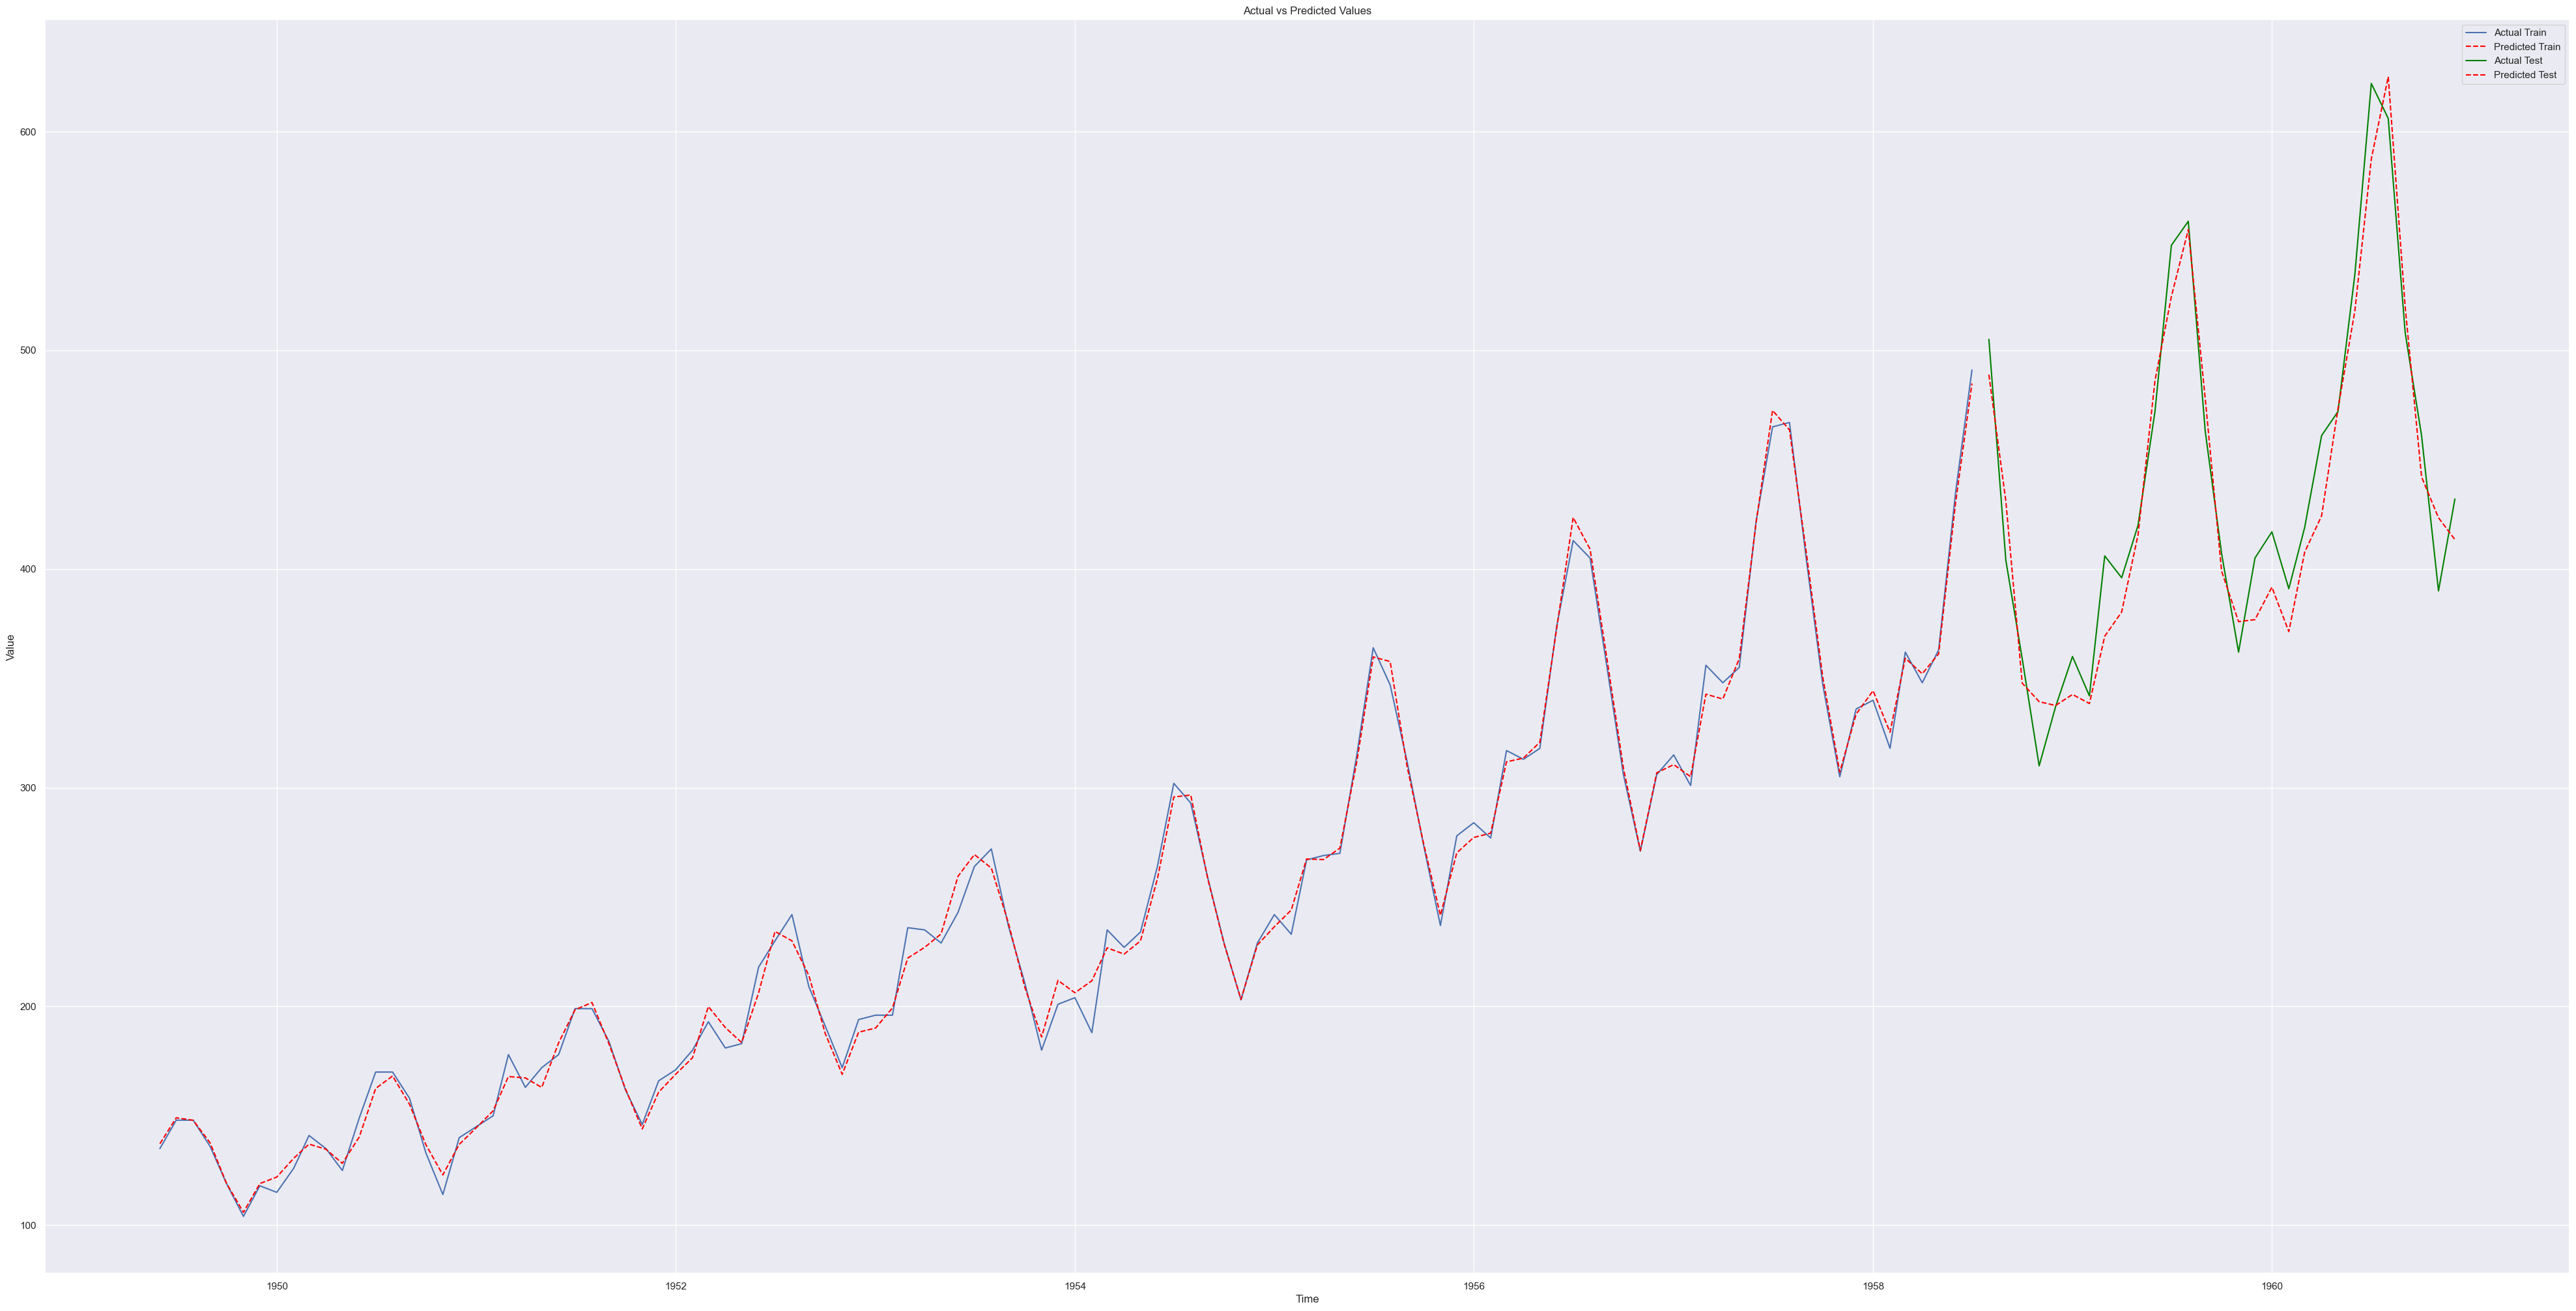

In [155]:
plt.figure(figsize=(50, 25))  # Set the figure size
plt.plot(y_train.index, y_train, label='Actual Train')  # Plot the actual values
plt.plot(y_train.index, y_pred_train, label='Predicted Train', linestyle='--', color='red')  # Plot the predicted values
plt.plot(y_test.index, y_test, label='Actual Test', color='green')  # Plot the actual values
plt.plot(y_test.index, y_pred_test, label='Predicted Test', linestyle='--', color='red')  # Plot the predicted values
plt.xlabel('Time')  # Label x-axis
plt.ylabel('Value')  # Label y-axis
plt.title('Actual vs Predicted Values')  # Title of the plot
plt.legend()  # Add a legend
plt.show()  # Display the plot